In [1]:
import numpy as np
import gudhi as gd

import matplotlib.pyplot as plt

# create a VR complex from a pointcloud

In [2]:
pointcloud = np.array([[0,0], [2,-0.2], [4,0.2], [0,-1.5], [2,-3], [4,-1], [3.8,-2.5]] )
epsilon = 12

rips_complex = gd.RipsComplex(points = pointcloud,
                                 max_edge_length= epsilon)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=len(pointcloud))


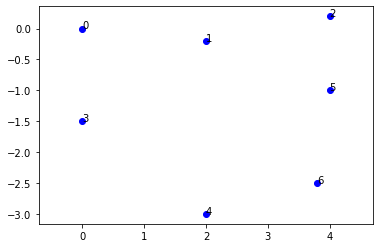

In [3]:
plt.figure()
plt.axis('equal')
for i in range(len(pointcloud)):
    plt.scatter(pointcloud[i][0], pointcloud[i][1], color = "blue")
    plt.text(pointcloud[i][0], pointcloud[i][1], i)

In [4]:
result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
print(result_str)
fmt = '%s -> %.2f'
for filtered_value in simplex_tree.get_filtration():
    print(fmt % tuple(filtered_value))

Rips complex is of dimension 6 - 127 simplices - 7 vertices.
[0] -> 0.00
[1] -> 0.00
[2] -> 0.00
[3] -> 0.00
[4] -> 0.00
[5] -> 0.00
[6] -> 0.00
[2, 5] -> 1.20
[0, 3] -> 1.50
[5, 6] -> 1.51
[4, 6] -> 1.87
[0, 1] -> 2.01
[1, 2] -> 2.04
[1, 5] -> 2.15
[1, 2, 5] -> 2.15
[1, 3] -> 2.39
[0, 1, 3] -> 2.39
[3, 4] -> 2.50
[2, 6] -> 2.71
[2, 5, 6] -> 2.71
[1, 4] -> 2.80
[1, 3, 4] -> 2.80
[4, 5] -> 2.83
[1, 4, 5] -> 2.83
[4, 5, 6] -> 2.83
[1, 6] -> 2.92
[1, 2, 6] -> 2.92
[1, 4, 6] -> 2.92
[1, 5, 6] -> 2.92
[1, 2, 5, 6] -> 2.92
[1, 4, 5, 6] -> 2.92
[0, 4] -> 3.61
[0, 1, 4] -> 3.61
[0, 3, 4] -> 3.61
[0, 1, 3, 4] -> 3.61
[2, 4] -> 3.77
[1, 2, 4] -> 3.77
[2, 4, 5] -> 3.77
[1, 2, 4, 5] -> 3.77
[2, 4, 6] -> 3.77
[1, 2, 4, 6] -> 3.77
[2, 4, 5, 6] -> 3.77
[1, 2, 4, 5, 6] -> 3.77
[3, 6] -> 3.93
[1, 3, 6] -> 3.93
[3, 4, 6] -> 3.93
[1, 3, 4, 6] -> 3.93
[0, 2] -> 4.00
[0, 1, 2] -> 4.00
[0, 2, 4] -> 4.00
[0, 1, 2, 4] -> 4.00
[3, 5] -> 4.03
[1, 3, 5] -> 4.03
[3, 4, 5] -> 4.03
[1, 3, 4, 5] -> 4.03
[3, 5, 6] ->

# compute persistence

In [5]:
simplex_tree.persistence()

[(1, (2.5, 2.8284271247461903)),
 (0, (0.0, inf)),
 (0, (0.0, 2.039607805437114)),
 (0, (0.0, 2.009975124224178)),
 (0, (0.0, 1.8681541692269403)),
 (0, (0.0, 1.5132745950421556)),
 (0, (0.0, 1.5)),
 (0, (0.0, 1.2))]

array([[0.        , 1.2       ],
       [0.        , 1.5       ],
       [0.        , 1.5132746 ],
       [0.        , 1.86815417],
       [0.        , 2.00997512],
       [0.        , 2.03960781],
       [0.        ,        inf]])

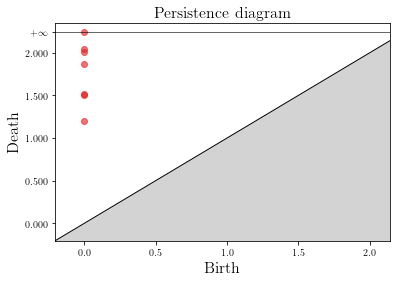

In [6]:
barcodes_0 = simplex_tree.persistence_intervals_in_dimension(0)
gd.plot_persistence_diagram(barcodes_0);
barcodes_0

array([[2.5       , 2.82842712]])

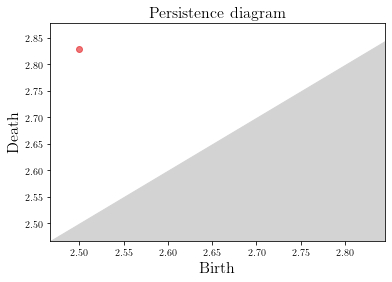

In [7]:
barcodes_1 = simplex_tree.persistence_intervals_in_dimension(1)
gd.plot_persistence_diagram(barcodes_1);
barcodes_1

# compute Betti curves

In [8]:
# HELPER FUNCTION
# given the ordered list of local contributions to the betti number
# returns a list of tuples (filtration, betti number characteristic)
def sum_local_contributions(local_contributions):

    betti_curve = []
    old_f, current_number = local_contributions[0]

    for filtration, contribution in local_contributions[1:]:
        if filtration > old_f:
            betti_curve.append([old_f, current_number])
            old_f = filtration

        current_number += contribution

    # add last contribution
    betti_curve.append([filtration, current_number])

    return betti_curve


# MAIN FUNCTION
# from a list of (birth, death) pairs computes the betti curves
# by assigning +1 to each birth filtration value
# and -1 to each death filtration value
# then sorts the list of contributions and sums them up
def betti_curve_from_persistence_list(barcodes):
    
    local_contributions = {} # dict {filtration: contribution}
    
    for birth, death in barcodes:
        local_contributions[birth] = local_contributions.get(birth, 0) + 1
        local_contributions[death] = local_contributions.get(death, 0) - 1

        
    # remove the contributions that are 0
    to_del = []
    for key in local_contributions:
        if local_contributions[key] == 0:
            to_del.append(key)

    for key in to_del:
        del local_contributions[key]

    # convert the dict into a list, sort it according to the filtration and sum the contributions
    return sum_local_contributions(sorted(list(local_contributions.items()), 
                                          key = lambda x: x[0])
                                  )
        


        

In [9]:
# WARNING
# when plotting a lot of points, drawing the lines can take some time
def plot_betti_curve(b_list, with_lines=False, title=None):
    plt.figure()
    plt.scatter([f[0] for f in b_list], [f[1] for f in b_list])

    # draw horizontal and vertical lines b/w points

    if with_lines:
        for i in range(1, len(b_list)):
            plt.vlines(
                x=b_list[i][0],
                ymin=min(b_list[i - 1][1], b_list[i][1]),
                ymax=max(b_list[i - 1][1], b_list[i][1]),
            )
            plt.hlines(y=b_list[i - 1][1], xmin=b_list[i - 1][0], xmax=b_list[i][0])

    plt.xlabel("Filtration")
    plt.ylabel("Betti Number")
    plt.title(title)

# Betti 0

In [10]:
barcodes_0

array([[0.        , 1.2       ],
       [0.        , 1.5       ],
       [0.        , 1.5132746 ],
       [0.        , 1.86815417],
       [0.        , 2.00997512],
       [0.        , 2.03960781],
       [0.        ,        inf]])

In [11]:
betti_curve_0 = betti_curve_from_persistence_list(barcodes_0)
betti_curve_0

[[0.0, 7],
 [1.2, 6],
 [1.5, 5],
 [1.5132745950421556, 4],
 [1.8681541692269403, 3],
 [2.009975124224178, 2],
 [2.039607805437114, 1],
 [inf, 0]]

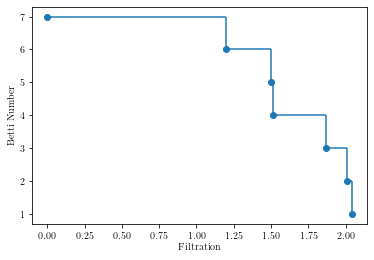

In [12]:
# lets not consider the point at inf
plot_betti_curve(betti_curve_0[:-1], with_lines=True)

# Betti 1

In [13]:
barcodes_1

array([[2.5       , 2.82842712]])

In [14]:
betti_curve_1 = betti_curve_from_persistence_list(barcodes_1)
betti_curve_1

[[2.5, 1], [2.8284271247461903, 0]]

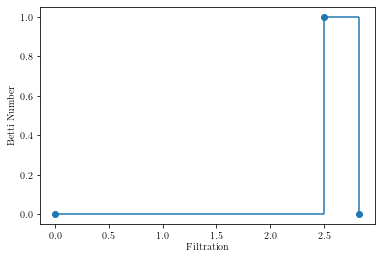

In [15]:
# lets add the point [0,0] to ease visualization
plot_betti_curve([[0,0]] + betti_curve_1, with_lines=True)